# 動的計画法を速く解こう！

** とくぷ(Twitter:@tokutokupooh, GitHub:tokupooh)**

[6日目](https://docs.google.com/document/d/160xW45I2v-MUkJF8TyaXhENCLJA243WOGdjK-G22UQM/edit)→ 7日目

この記事は[みゅーもり Advent Calendar](https://adventar.org/calendars/3429)の7日目の記事になります。

本記事では様々な場面で用いられている動的計画法を具体例に基づき、解法について概説します。


具体的には
1. Value Function Iteration(VFI)
2. Endogenous Grid Method(EGM)

について仕組みと実装を紹介します。


例として取り上げるモデルについては詳細は省きますが、
さらに知りたい方については
[Ljungqvist and Sargent(2018)](https://mitpress.mit.edu/books/recursive-macroeconomic-theory-fourth-edition)
の17章がおすすめです。


前提知識としては
- 簡単な微分の知識
- 動的計画法とはなにか

のみを仮定します。


## モデル

この節では、本記事で注目するモデルについて概説します。


次のような最大化問題を考えます。

### 定式化
\begin{equation*}
\max_{\{c_t,a_{t+1}\}_{t=0}^{\infty}}\sum_{t=0}^{\infty} \beta^t u(c_t)
\end{equation*}
subject to 
\begin{equation*}
c_t + a_{t+1} = (1+r)a_t + wz_t
\end{equation*}
\begin{equation*}
a_{t+1} \ge 0
\end{equation*}
\begin{equation*}
\log z_{t+1} = \rho \log z_t + \epsilon_t
\end{equation*}

- $u$: 効用関数

- $c$: 消費
- $a$: 資産
- $\beta$: 割引因子
- $r$: 利子率
- $w$: 賃金
- $z$: 個人の生産性



直観的にはこのモデルは次のように考えることができます。

無限期間生きる家計が生涯における割引期待効用を最大にするように消費、貯蓄の計画を決定します。

家計は毎期一定の所得を手に入れることができますが、そうした所得はランダムに決まる自らの生産性に依存します。

所得がランダムに決まるので、所得が少ない時期が長く続く場合は借金をして消費を増やそうとするかもしれません。
しかし借金がここでは許されていないので、手に入れた所得をすべて消費に回します。

### ベルマン方程式

以上のような流列問題はベルマン方程式を用いて定式化しなおすことができます。ベルマン方程式は次のようになります。

\begin{equation*}
v(a,z) = \max_{a'}\left[u(c) + \beta E v(a',z') \right]
\end{equation*}
subject to

\begin{equation*}
c + a' = (1+r)a + wz
\end{equation*}
\begin{equation*}
a_{t+1} \ge 0
\end{equation*}
\begin{equation*}
\log z' = \rho \log z + \epsilon
\end{equation*}


### Parametarization

ここでこのモデルを計算するためにパラメータを特定化しましょう。

- $u(c) = \frac{c^{1-\sigma}}{1-\sigma}$
- $\beta=0.96$
- $\sigma=3.0$: 相対的リスク回避度
- $\phi =0.0$: 借入制約

AR(1)プロセスは取り扱いのしやすいマルコフプロセスによって近似します。
詳細についてはTauchen(1986), Rouwenhorst(1995)をご覧ください。

ここでは生産性のグリッドを$z$,生産性の推移行列を$\Pi$とし、
AR(1)プロセスが以下のマルコフプロセスで記述できるとします。

- $z = [0.2,1.0]$
- $\Pi = \begin{bmatrix}0.7 & 0.3\\ 0.1 & 0.9\end{bmatrix}$


## Value Function Iteration

VFIは縮小写像の定理より収束することが知られており、安定的に動的計画法を解くことができます。

ただしモデルの構造などを利用していないことから計算速度は遅いという欠点があります。


### アイディア


Value functionを予想したうえで、その予想値のもとでValue functionを繰り返し更新していくことで解を求めます。

Value functionはベルマン方程式を利用して次のように更新していきます。

\begin{equation*}
v^{(n)}(a,z) = \max_{a'} \left[u(c) + \beta Ev^{(n-1)}(a',z')\right]
\end{equation*}

今回はVFIの仕組みを概観することが目的なので、最も単純なVFIについて紹介します。

### アルゴリズム

1. 今期の資産$a$と来期の資産$a'$をそれぞれ$n$個に区切る $\{a_i,a'_j\}_{i,j=1}^n$
2. 価値関数の初期値を定める
3. 収束の基準を定める
4. 効用関数を各グリッドポイントにおいて計算する
5. 各状態変数のグリッドについて $v^{(n)}(a,z) = \max_{a'} \left[u(c) + \beta Ev^{(n-1)}(a',z')\right]$　を計算する
6. $v^{(n)}$と$v^{(n-1)}$の誤差が十分小さくなれば、計算を終わらせる。そうでなければ価値関数の初期値を$v^{(n)}$と設定し、5に戻る。


以下ではアルゴリズムについて補足を行います。

**step 4**

効用関数を各グリッドポイントで計算しますが、ここでは$a,a',z$のすべての組について計算する必要があります。

そのため効用関数の行列は$n\times n \times 2$となります。

**step 5**

ステップ5では具体的には状態変数の組について
\begin{equation*}
v^{(n)}(a_i,z_h)= \max_{a_j}\{u((1+r)a_i + wz_h- a'_j)+ \beta  \sum_{l=1}^{2} \Pi_{jl}v^{(n-1)}(a' _j z'_l)\} 
\end{equation*}
を計算していきます。



In [1]:
#=利用するパッケージ=#
using LinearAlgebra
using BenchmarkTools
using Plots
gr() 

Plots.GRBackend()

In [2]:
struct Model{TI<:Integer, TF<:AbstractFloat,TV<:Vector,TM<:Matrix}
    
    # EGM, VFIともに同じ設定で解くので共通部分をまとめて使いやすくする

    β::TF # 割引因子
    σ::TF # 相対的リスク回避度
    ϕ::TF # 正の値を取る借入制約(どれだけ借りられるかを示す)
    
    a2grid::TV #Array{TF,1} # 資産グリッド
    na::TI # 資産グリッドのサイズ
    
    zgrid::TV #Array{TF,1} # ショックのリッド
    nz::TI # ショックグリッドのサイズ
    Π::TM #Array{TF,2} # 推移行列

    maxiter::TI　# 反復上限回数
    tol::TF # 誤差許容度

end

In [3]:
function Construct(;β=0.96,
                    σ=3.0,
                    ϕ=0.0,
                    a2min=0.0,
                    a2max=10.0, 
                    na=500)    
    
    # 借入制約を含んだグリッドを作る
    # ここでは借入制約付近にグリッドポイントが多くなるように作成する
    dist_grid  = (a2max-(a2min- ϕ))/(na-1).^2 # グリッドポイント間の距離
    indices   = collect(Int64,1:na) # グリッドのインデックス
    a2grid =  (a2min-ϕ) .+ dist_grid*(indices.-1).^2 # 資産グリッドの形成
    
    # ショックのグリッドを作る
    zgrid = [0.2, 1.0] # 生産性ショック
    nz = length(zgrid)
    Π =[0.7 0.3; 0.1 0.9] # 推移行列  
    
    # 反復に関する設定
    maxiter = 10000 # 反復上限回数
    tol = 1e-13 # 誤差許容度
    
    return  Model(β,σ,ϕ,a2grid,na,zgrid,nz,Π,maxiter,tol)  
end

Construct (generic function with 1 method)

In [4]:
m = Construct() # パラメータなどを含んだオブジェクトを作った

Model{Int64,Float64,Array{Float64,1},Array{Float64,2}}(0.96, 3.0, 0.0, [0.0, 4.01605e-5, 0.000160642, 0.000361444, 0.000642568, 0.00100401, 0.00144578, 0.00196786, 0.00257027, 0.003253  …  9.64253, 9.68193, 9.72141, 9.76096, 9.8006, 9.84032, 9.88012, 9.92, 9.95996, 10.0], 500, [0.2, 1.0], 2, [0.7 0.3; 0.1 0.9], 10000, 1.0e-13)

In [5]:
@inline function VFI(m::Model)
    
    # 要素価格
    r = 0.03 # 利子率
    w = 1.0  # 賃金
    
    # ペナルティ
    neg = -1e10
    # 効用関数
    @inline u(c,σ) = c > 1e-10 ? (c^(1.0-σ))/(1.0-σ) : neg
    
    
    #=利用する変数の初期化=#
    util = zeros(m.na,m.na,m.nz)
    v0 = ones(m.na,m.nz) #価値関数の初期予想
    Tv = similar(v0) #アップデートされた価値関数
    DEV = similar(v0) # \beta * E V(a',z')の値を入れる行列
    pol_a = similar(v0) # 資産に関する政策関数
    pol_c = similar(v0) # 消費に関する政策関数
    
    # 効用行列の計算　step 4
    @inbounds  for z in eachindex(m.zgrid)
        @inbounds for j in eachindex(m.a2grid)
            @inbounds for i in eachindex(m.a2grid)
                c = w*m.zgrid[z] + (1.0+r)*m.a2grid[i] - m.a2grid[j]
                util[i,j,z] = u(c, m.σ)
            end
        end
    end
    
    #= VFIの実行 =#
    for VFI_it in 1: m.maxiter 
            
            #=step 5=#
            DEV = m.β*v0*m.Π'　#\beta * E V(a',z')の部分を先に計算しておく
            @inbounds  for z in eachindex(m.zgrid)
                @inbounds for i in eachindex(m.a2grid)
                    vmin = neg
                    @inbounds for j in eachindex(m.a2grid)
                        v = util[i,j,z] + DEV[j,z]
                        if v > vmin # 計算のたびに大きいものを代入していく　最適化ステップ
                            vmin = v
                            Tv[i,z] = vmin
                            pol_a[i,z] = m.a2grid[j]
                        end
                    end
                    # 政策関数を予算制約から計算
                    pol_c[i,z] =  w*m.zgrid[z] +(1.0+r)*m.a2grid[i] - pol_a[i,z]
                end
            end
            
            #=step 6 =#
            err = maximum(abs.(Tv-v0)) # 誤差の確認
            v0 = copy(Tv) # アップデートしたものを予想のものに代入
            if err < m.tol #十分に誤差が小さくなったかを確認
                break
            end
            
            if VFI_it == m.maxiter
                println("The model does not converge...")
            end
        end   
    
    return v0, pol_a,pol_c
end

VFI (generic function with 1 method)

In [6]:
v, pol_a_VFI, pol_c_VFI = VFI(m)

([-61.5264 -26.669; -61.5212 -26.6687; … ; -11.7195 -10.4462; -11.6891 -10.4265], [0.0 0.451243; 0.0 0.451243; … ; 9.369 10.0; 9.40783 10.0], [0.2 0.548757; 0.200041 0.548798; … ; 1.08976 1.25876; 1.09217 1.3])

In [7]:
@benchmark VFI(m)

BenchmarkTools.Trial: 
  memory estimate:  32.22 MiB
  allocs estimate:  3668
  --------------
  minimum time:     1.609 s (0.63% GC)
  median time:      1.764 s (1.15% GC)
  mean time:        1.735 s (2.25% GC)
  maximum time:     1.831 s (1.11% GC)
  --------------
  samples:          3
  evals/sample:     1

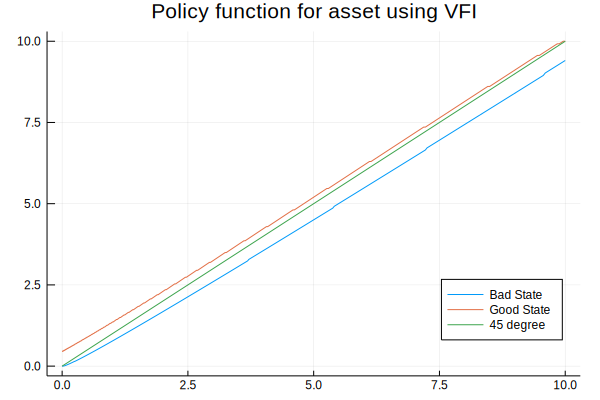

In [8]:
labels=["Bad State","Good State"]
plot(m.a2grid,pol_a_VFI, label=labels,legend=:bottomright)
plot!(m.a2grid,m.a2grid, label ="45 degree",legend=:bottomright)
title!("Policy function for asset using VFI")

このようにVFIでは約1.7秒でこのような政策関数を得ることが出来ました。　

政策関数のプロットをみると生産性が低く、資産が少ない場合は来期に向けた貯蓄をしない様子が見受けられます。

## Endogenous Grid Method


次にEndogenous Grid Method(EGM)について紹介します。

VFIは操作変数に関して最適化を行うステップが存在し、この部分の計算量が状態変数の数に応じて非常に多くなってしまいます。

特に操作変数を連続値として解くようなステップではnumerical solverを状態変数のグリッドポイントごとに使います。

そのためVFIよりも計算時間がかかることが予想されます。

しかしモデルの構造を十分に生かすことでnumerical solverの利用を回避し、計算速度を大幅に上げることができます。

### アイディア

前述のモデルの1階条件から求められるオイラー方程式は次のようになります。

\begin{equation*}
u'(c_t)= \beta(1+r)E_t u'(c_{t+1})
\end{equation*}

仮定より$u'$は逆関数が取れるので、$c_t = u^{'-1}\left( \beta (1+r)E_t u'(c_{t+1})\right)$とすることができます。

ここからわかることは$c_{t+1}$の値が分かっていれば自動的に$c_t$が決定されるということです。

したがってEGMではt+1期についてのグリッドを作ることがポイントになっています。



### アルゴリズム

1. 来期期の資産,a'をn個に区切る。
2. 消費に関する政策関数,$c' = g_0(a',z')$を予想する。
3. 収束の基準を定める。
4. $c  = u^{'-1}\left( \beta (1+r)E u'(g_0(a',z'))\right)$を利用して今期の消費$\text{ctil} $を求める
5. 4.で求めた消費と$a'$のグリッドをもとに$a$のグリッドを求める
6. 4,5から得られる消費関数$\text{ctil}= g(a,z) $を$a'$で評価しなおす。
7. 消費関数の誤差が十分小さくなれば、計算を終わらせる。そうでなければ消費関数をアップデートし、4に戻る。

以下ではアルゴリズムについていくつかの補足を行います。

説明のために a'のグリッドを$a'=\{a'_1,...,a'_{na}\}$,zのグリッドを$z= \{z_1,...,z_{nz}\}$とします。


**step 4**

オイラー方程式から今期の消費量を求めますが、具体的には

\begin{equation*}
\text{ctil}_{ij} = u^{'-1}\left(\beta(1+r) \sum_{l = 1}^{nz} \Pi_{jl} u'(g_0(a'_i,z_l))\right)
\end{equation*}

とすることで各要素を計算します。

**step 5**

ステップ5で求められた今期の資産を$a^\ast$とします。

予算制約から$a^\ast$の各要素は次のように求めることができます。

\begin{equation*}
a^\ast_{ij} = \frac{a'_i + ctil_{ij} - wz_j}{1+r}
\end{equation*}

ここで分かるように$a^\ast$は行列となります。VFIではt期の資産のグリッドはベクトルですから、この点は大きく異なります。

ここで$a'_1= -\phi$であるので、$a^\ast_{1j}$は借入制約がバインドするような最大の今期の資産となります。


**step 6**

ステップ4,5から消費関数は$\text{ctil}_{ij}= g(a^\ast_{ij},z_j)$として得られます。

ただしここで得られた消費関数は$a^\ast$と$z$上で定義されていますが、オリジナルの消費関数$g_0(a'_i,z_j)$は$a'$と$z$上で定義されています。

そこで$g(a^\ast_{ij},z_j)$を$a'$と$z$上で線形補間をすることで評価し直し、消費関数をアップデートします。($g_1(a'_i,z_j)$とする。)

ただし借入制約の存在には注意が必要です。借入制約の存在から下限については線形の外挿をするのではなく、ひと手間必要になります。


ステップ5で紹介したように$a^\ast_{1,j}$は借入制約がバインドする時の今期の資産の量です。

そこで$a'_i \le a^\ast_{1,j}$となるような$a'$のグリッドポイントについては次のように消費関数を求めます。
\begin{equation*}
g_1(a'_i,z') = (1+r)a'_i + wz_j - a'_1
\end{equation*}




In [9]:
@inline function EGM(m::Model)

    #=便利な関数の設定=#
    @inline u′(c, σ) = (1.0/c)^(σ) # 限界効用関数
    @inline u′_inv(val, σ) = (1.0/val)^(1.0/σ) # 限界効用の逆関数
    
    # 要素価格
    r = 0.03 # 利子率
    w = 1.0  # 賃金
    
    # 簡素化のために設定
    #a2mat = repeat(m.a2grid,1,m.nz)
    #zmat = repeat(m.zgrid', m.na)

    #= 初期化 =#
    a1= zeros(m.na,m.nz) # 内生的に決定される今期の資産のグリッド
    wealth = (1.0+r)*m.a2grid .+ w*m.zgrid' #資産に関する政策関数のために必要
    ctil =similar(a1) # 内生的に決まる消費

    pol_a = similar(a1) # 資産に関する消費関数
    pol_c = ones(m.na,m.nz) # 消費に関する政策関数の初期予想
    pol_c1 = similar(a1) # updateする消費に関する政策関数
    
    for iter in 1:m.maxiter
        # オイラー方程式から内生的にcを求める
        ctil .= u′_inv.((u′.(pol_c, m.σ)*m.β*(1.0+r)*m.Π'), m.σ) # step4
        # 予算制約を利用して内生的にaのグリッドを作る
        @. a1 = (m.a2grid + ctil - w*m.zgrid')/(1.0+r) # step 5
        
        # 政策関数の更新 
        pol_c1 = policyinterp(m,r,w,a1,ctil,pol_c1) # step 6
        err = maximum(abs.(pol_c1-pol_c)) # 誤差の計算
        pol_c =copy(pol_c1) #　政策関数のアップデート

        if err < m.tol # step 7
            pol_a = wealth - pol_c # 資産に関する政策関数を求める
            break
        end
        
        if iter == m.maxiter
            println("The model does not converge...")
        end
    end
   
    return pol_a, pol_c
end

EGM (generic function with 1 method)

In [10]:
@inline function policyinterp(m::Model, r0, w0, a1,
                               pol_c, pol_c_u)
    
    #政策関数を線形補間する
    @inbounds for (i_z, v_z) in enumerate(m.zgrid)
        @inbounds for (i_a, v_a) in enumerate(m.a2grid)
            if v_a <= a1[1, i_z] # 借入制約にかかっている時はこのように消費を決定する
                pol_c_u[i_a, i_z] = (1.0+r0)*v_a + w0*v_z - m.a2grid[1]

            elseif  v_a >= a1[end, i_z] # 外挿は線形
                d =(v_a-a1[end, i_z])*(pol_c[end, i_z] - pol_c[end-1, i_z])/(a1[end, i_z]-a1[end-1, i_z])
                pol_c_u[i_a,i_z] = pol_c[end, i_z] +  d
                
            else #定義域内でも線形補間
                @views ind = searchsortedlast(a1[:,i_z],v_a)
                ind1  = ind + 1
                d = (v_a-a1[ind, i_z])*(pol_c[ind1, i_z] - pol_c[ind, i_z])/(a1[ind1, i_z]-a1[ind, i_z])
                pol_c_u[i_a, i_z] = pol_c[ind, i_z] + d
            end    
        end
    end
    return pol_c_u
end

policyinterp (generic function with 1 method)

In [11]:
pol_a_EGM, pol_c_EGM = EGM(m)

([0.0 0.448097; 0.0 0.448132; … ; 9.3614 10.0786; 9.40087 10.1182], [0.2 0.551903; 0.200041 0.55191; … ; 1.09736 1.18016; 1.09913 1.18184])

In [12]:
@benchmark EGM(m)

BenchmarkTools.Trial: 
  memory estimate:  23.06 MiB
  allocs estimate:  2978
  --------------
  minimum time:     138.672 ms (2.32% GC)
  median time:      170.183 ms (2.66% GC)
  mean time:        173.226 ms (5.13% GC)
  maximum time:     276.292 ms (38.69% GC)
  --------------
  samples:          29
  evals/sample:     1

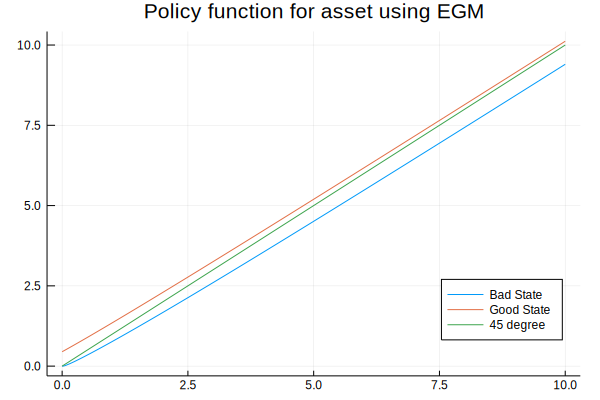

In [13]:
labels=["Bad State","Good State"]
plot(m.a2grid,pol_a_EGM, label=labels,legend=:bottomright)
plot!(m.a2grid,m.a2grid, label ="45 degree",legend=:bottomright)
title!("Policy function for asset using EGM")

EGMの場合は約0.17秒で上のプロットのような政策関数が得られることが分かります。
これは先ほどのVFIに比べて**10倍**高速になっています。

VFIで求められた政策関数とほぼ概形は同じで、資産が少ないうえに生産性が低い場合には貯蓄を行わないような状況になっています。

EGMで得られた消費関数は線形補間を行っていることから滑らかになっています。


## 結論

本記事ではベルマン方程式を解く際に使われる2つの手法について概説しました。　

VFIは非常に安定的な解法ですが、モデルの構造をうまく利用するEGMを用いることで
同様の答えを**10倍**速く手に入れることができます。

EGMのアイディアは理解するまでに時間がかかるかもしれませんが、コーディングは非常に簡単でおすすめです。

ぜひみなさんもEGMを利用することで、人生を豊かにしてみてください。
